<a href="https://colab.research.google.com/github/claudelepere/ML_GitHub/blob/main/jobs_EN_11_0_24000_samples_macro_epoch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q accelerate
!pip install -q huggingface_hub
!pip install -q scikit-learn
!pip install -q transformers datasets  # transformers and datasets are Hugging Face libraries
!pip install -q wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import datetime
import json
import numpy as np
import os
import pandas as pd
import pickle
import sys
import time
import torch
import torch.nn.functional as F
import wandb

from datasets               import DatasetDict
from google.colab           import auth, drive, files, userdata
from huggingface_hub        import create_branch, create_repo, HfApi, login, upload_file, hf_hub_download, whoami
from huggingface_hub.errors import RepositoryNotFoundError
from sklearn.metrics        import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, accuracy_score, hamming_loss, classification_report,  precision_recall_fscore_support
from torch.optim            import AdamW
from torch.utils.data       import DataLoader
from tqdm.auto              import tqdm
from transformers           import EvalPrediction, LongformerTokenizerFast, LongformerForSequenceClassification, Trainer, TrainingArguments
from torch.nn               import BCEWithLogitsLoss, Module

## Google Cloud Authentication

In [ ]:
auth.authenticate_user()  # user = c.lepere@ictjob.be

## Get skills and jobs

In [ ]:
skills         = 11
all_rows_low   = 0
all_rows_high  = 24000 # 120 12000 24000
num_datapoints = all_rows_high - all_rows_low

datasetDict_zip_file_name = f"dataset_EN_{skills}_{all_rows_low}_{all_rows_high}.zip"
datasetDict_dir_name      = os.path.splitext(datasetDict_zip_file_name)[0]

print(f"datasetDict_zip_file_name: {datasetDict_zip_file_name}")
print(f"datasetDict_dir_name     : {datasetDict_dir_name}")
print()

datasetDict_zip_file_name: dataset_EN_11_0_24000.zip
datasetDict_dir_name     : dataset_EN_11_0_24000



## Averages
<pre>
- per sample: metrics are computed for each sample (= for each instance, = for each row of y_true and y_pred), and then averaged across all samples.
- per label : metrics are computed for each label separately, and then averaged across all labels.
- per batch : metrics are computed for each batch, and then averaged across all batches.

- 'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
           Gives more weight to frequent labels → best for imbalanced datasets where frequent labels are more important.
- 'macro': Calculate metrics for each label separately, and find their unweighted mean.
           This does not take label imbalance into account. This is fine for balanced datasets but not for imbalanced datasets since rare labels are given equal weights.
           Averages the metric for each label without considering their imbalance, without considering label frequency.
           When to use: when wanting equal importance for all labels, including rare ones.
           Treats all labels equally → best when you care about rare labels as much as frequent ones.
- 'weighted': Calculate metrics for each label separately, and find their average weighted by support (= the number of true instances for each label). This alters ‘macro’ to account for label imbalance;
              it can result in an F-score that is not between precision and recall.
              Averages per label weighted by their support, without considering label frequency.
              When to use: when wanting to reflect label imbalance (common labels contribute more).
              Like macro but considers label frequency → best if you want a compromise between macro and micro.
- 'samples': Calculate metrics per sample instead of per label, and find their average (only meaningful for multilabel-classification where this differs from accuracy_score).
             Computes the metric per sample and then averages across all samples.
             When to use: when each sample has multiple correct labels.

- 'macro' or 'weighted' AUC is often best because AUC isn't as affected by class imbalance as F1/Precision/Recall
- 'macro'      AUC: usually the best because it treats all labels equally, avoiding the dominance of frequent labels
- 'weighted'   AUC: similar to macro but considers label frequency
- 'macro'   PR AUC: best for imbalanced datasets because it treats rare labels fairly
- 'weighted PR AUC: also good, but slightly biased toward frequent labels

PR AUC is better than ROC AUC when you care about positive examples in imbalanced data.
</pre>

In [ ]:
training_average   = 'samples'              # 'weighted' (best) or 'samples
evaluation_average = 'macro'                # 'macro'    (best) or 'weighted'
test_average       = evaluation_average
prediction_average = 'micro'                # 'micro'    (best) or 'samples' (prediction of unseen datapoints)

## Tune thresholds?

In [ ]:
threshold_tuning = True

## Upload to HF Hub?

In [ ]:
upload_to_HF = True
repo_id      = ''
timestamp    = ''


## Hugging Face Hub (HF Hub) authenticate

In [ ]:
if upload_to_HF is True:

  os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")    # Store the key in os.environ
  hf_token               = os.environ.get('HF_TOKEN')

  login(token=hf_token)

  # Check
  user = whoami(token=hf_token)
  assert user['name'] == 'claudelepere', f"{user['name']} is not claudelepere"
  print(f"user: {user}")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


user: {'type': 'user', 'id': '66ec3d5f61228b02f8780beb', 'name': 'claudelepere', 'fullname': 'Claude Lepère', 'isPro': False, 'avatarUrl': 'https://cdn-avatars.huggingface.co/v1/production/uploads/66ec3d5f61228b02f8780beb/gvnf9pvm2KvE90ETMUQo3.jpeg', 'orgs': [], 'auth': {'type': 'access_token', 'accessToken': {'displayName': 'jobs_token', 'role': 'fineGrained', 'createdAt': '2025-01-04T17:44:35.493Z', 'fineGrained': {'canReadGatedRepos': False, 'global': [], 'scoped': [{'entity': {'_id': '66ec3d5f61228b02f8780beb', 'type': 'user', 'name': 'claudelepere'}, 'permissions': ['repo.content.read', 'repo.write']}]}}}}


## repo_id, branch, model and dataset repos on HF Hub
**1 repo = 1 model and 1 tokenizer**

**branch = revision**

In [ ]:
if upload_to_HF is True:

  if threshold_tuning:
    repo_id   = 'claudelepere/jobs_EN_11_0_24000_tuned_thresholds'
    #repo_id   = 'claudelepere/jobs_EN_11_0_12000_tuned_thresholds'
  else:
    repo_id   = 'claudelepere/jobs_EN_11_0_24000'
    #repo_id   = 'claudelepere/jobs_EN_11_0_12000'
  timestamp = f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

  model_repoUrl   = create_repo(repo_id=repo_id, repo_type="model",   private=True, exist_ok=True)
  dataset_repoUrl = create_repo(repo_id=repo_id, repo_type="dataset", private=True, exist_ok=True)

  #create_branch(repo_id=repo_id, repo_type="model",   branch=branch, exist_ok=True)
  #create_branch(repo_id=repo_id, repo_type="dataset", branch=branch, exist_ok=True)

  print(f"Model Repo Url: {model_repoUrl} created successfully as a private repo")
  print(f"Dataset Repo Url: {dataset_repoUrl} created successfully as a private repo")

Model Repo Url: https://huggingface.co/claudelepere/jobs_EN_11_0_24000_tuned_thresholds created successfully as a private repo
Dataset Repo Url: https://huggingface.co/datasets/claudelepere/jobs_EN_11_0_24000_tuned_thresholds created successfully as a private repo


## HF model card
Model card here => README.md on the HF Hub.

In [ ]:
model_card = """
---
tags:
- "24000"
---
# Model
Model fine-tuned on higly-imbalanced multilabel classification.

## Model details
- Language: English
- Task: Multilabel classification
- Architecture: Longformer
- Pretrained model: [allenai/longformer-base-4096](https://huggingface.co/allenai/longformer-base-4096)
- Framework: Pytorch
- Version 1.0.0

## Training Data
- skills: 11
- 24000 job datapoints

## Fine-tuning parameters
- batch size: 8
- gradient accumulation: 4
- fp16 precision
- input tokens max length: 1024
- epochs: 8
- learning rate: 1e-5
- tuned thresholds
- attention window size: 1024
"""

## Save locally and upload model card to HF Hub

In [ ]:
if upload_to_HF is True:

  with open("model_card.md", "w") as f:
    f.write(model_card)

  upload_file(
      path_or_fileobj = 'model_card.md',  # path to a file or a file-like object
      path_in_repo    = 'README.md',
      repo_id         = repo_id
  )

In [ ]:
"""
# Check the Python version
print(sys.version)
print()

# Get the installed packages (you can see that conda is not installed (do not install it))
!pip list
print()

# Check system information
!cat /etc/os-release
!uname -m
print()

# Check the GPU details (only if the runtime type is T4 GPU)
#!nvidia-smi
#print()

# Check RAM
!free -h
print()

# Check disk space
!df -h
print()

# Get environment variables
for key, value in os.environ.items():
    print(f"{key}: {value}")
"""
!python -V

Python 3.11.11


In [ ]:
print(f"currentdir: {os.getcwd()}")

currentdir: /content


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


## Out Of Memory (OOM)

### OOM: reduce batch size
      small sizes (1 to 32):            PROs: better generalization in some cases
                                        CONs: may produce noisier gradients
      large sizes (128, 256, or higer): PROs: gradients are smoother, leading to more stable training
                                        CONs: poorer generalization (overfitting) in some cases
      intermediate sizes (32, 64):      combines the benefits of small and large sizes

In [ ]:
batch_size = 8

### OOM: enable gradient accumulation

* compensate for smaller batch sizes by accumulating gradients over several steps
* **effective batch size** = per-device batch size x gradient acumulation steps
* in each iteration, the model computes the gradients, these gradients are immediately used to update the model parameters

WARNING: gradient_accumulation_steps may not be None => comment it in TrainingArguments

In [ ]:
gradient_accumulation_steps = 4

### OOM: use PYTORCH_CUDA_ALLOC_CONF to handle memory fragmentation

In [ ]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

### OOM: check for and kill zombie processes

In [ ]:
!ps aux | grep python
!kill -9 <PID>
if torch.cuda.is_available():
  !nvidia-smi
  print(torch.cuda.memory_summary())

root          87  3.4  0.0      0     0 ?        Z    20:35   0:13 [python3] <defunct>
root          88  0.1  0.0  63640 50896 ?        S    20:35   0:00 python3 /usr/local/bin/colab-file
root         137  1.0  0.1 779640 127020 ?       Sl   20:35   0:04 /usr/bin/python3 /usr/local/bin/j
root         929  9.6  1.4 12133720 1301712 ?    Ssl  20:38   0:20 /usr/bin/python3 -m colab_kernel_
root         971  0.3  0.0 544684 20000 ?        Sl   20:38   0:00 /usr/bin/python3 /usr/local/lib/p
root        2067  0.0  0.0   7376  3324 ?        S    20:42   0:00 /bin/bash -c ps aux | grep python
root        2069  0.0  0.0   6484  2260 ?        S    20:42   0:00 grep python
/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `kill -9 <PID>'
Tue Feb 25 20:42:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----

### OOM: use fp16 (half precision) mixed precision training
reduces memory requirements by up to 50%

In [ ]:
fp = 'fp16'

### OOM: limit the number of GPU workers:
* 0 (default) or 1
* in Colab dataloader_num_workers = 1

### OOM: reduce model size or input tokens
* LongformerTokenizer.from_pretrained('allenai/longformer-base/large-4096'): large/base: 435M/149M parameters
* max_length: 4096 max for Longformer
* a single word can be equal to several tokens; stop words are **NOT discarded**!
* word_text_length_counts_sorted:
      jobs count                 : 50000
      jobs count under  512 words: 44794  89.59%
      jobs count under  640 words: 47894  95.79%
      jobs count under  768 words: 49123  98.25%
      jobs count under  896 words: 49691  99.38%
      jobs count under 1024 words: 49917  99.83%
      jobs count under 2048 words: 50000 100.00%
      jobs count under 4096 words: 50000 100.00%

In [ ]:
#max_length =  768    #      37 min    #
max_length = 1024    #      38 min    # GPU RAM: 12.2 / 40 GB
#max_length = 2048    # 1 hr 10 min    # GPU RAM: 21.4 / 40 GB
#max_length = 4096    # 2 hr 10 min    # GPU RAM: 39.5 / 40 GB => OutOfMemoryError

### OOM: free up GPU memory

In [ ]:
torch.cuda.empty_cache()

### OOM: reduce the number of transformers layers

In [ ]:
# hidden_layers = 6  # default:12

## epoch
* 1 epoch is a complete pass through the entire training dataset
* with n datapoints and batch size = b, n/b iterations to complete 1 epoch
* 1 iteration is a single update of the model's parameters

In [ ]:
epochs = 5

## learning rate
* A common rule is to scale the learning rate proportionaly with the effective batch size
* **note: get_linear_schedule_with_warmup**

In [ ]:
learning_rate = 1e-5  # 1e-5 x 32/8

## threshold
default: 0.5

In [ ]:
threshold = 0.5

## attention window size

In [ ]:
attention_window = 1024 #512

## Upload and unzip job dataset

In [ ]:
def upload_unzip_dataset(file_name=datasetDict_zip_file_name):
  # Check if the file exists
  if not os.path.exists(file_name):
    print(f"'{file_name}' not found in /content. Uploading...")
    uploaded_files = files.upload()                              # Prompt file upload dialog
    if file_name not in uploaded_files:
      raise FileNotFoundError(f"'{file_name}' was not uploaded. Please try again.")
    print(f"'{file_name}' successfully uploaded to /content")
    uploaded_file_name = list(uploaded_files.keys())[0]          # Get the name of the uploaded file

    !unzip {uploaded_file_name}

    unzipped_dir_name = os.path.splitext(uploaded_file_name)[0]
    assert unzipped_dir_name==datasetDict_dir_name, "unzipped_dir_name != datasetDict_dir_name"
  else:
    print(f"'{file_name}' already exists in /content.")

upload_unzip_dataset(datasetDict_zip_file_name)

'dataset_EN_11_0_24000.zip' not found in /content. Uploading...


Saving dataset_EN_11_0_24000.zip to dataset_EN_11_0_24000.zip
'dataset_EN_11_0_24000.zip' successfully uploaded to /content
Archive:  dataset_EN_11_0_24000.zip
  inflating: dataset_EN_11_0_24000/dataset_dict.json  
  inflating: dataset_EN_11_0_24000/test/data-00000-of-00001.arrow  
  inflating: dataset_EN_11_0_24000/test/dataset_info.json  
  inflating: dataset_EN_11_0_24000/test/state.json  
  inflating: dataset_EN_11_0_24000/train/data-00000-of-00001.arrow  
  inflating: dataset_EN_11_0_24000/train/dataset_info.json  
  inflating: dataset_EN_11_0_24000/train/state.json  
  inflating: dataset_EN_11_0_24000/validation/data-00000-of-00001.arrow  
  inflating: dataset_EN_11_0_24000/validation/dataset_info.json  
  inflating: dataset_EN_11_0_24000/validation/state.json  


## W&B initialization (not used now)

In [ ]:
run_name = f"EN_{skills}_{all_rows_low}_{all_rows_high}_ml{max_length}_ep{epochs}_lr{learning_rate}_th{threshold}_at{attention_window}_{fp}"

if 'gradient_accumulation_steps' not in globals():
  run_name = f"{run_name}_ba{batch_size}"
else:
  run_name = f"{run_name}_ba{batch_size}x{gradient_accumulation_steps}"

print(f"run_name: {run_name}")

run_name: EN_11_0_24000_ml1024_ep8_lr1e-05_th0.5_at1024_fp16_ba8x4


In [ ]:
os.environ["WANDB_API_KEY"] = userdata.get("WANDB_API_KEY")        # Store the key in os.environ
wandb_api_key               = os.environ.get('WANDB_API_KEY')
wandb.login(key=wandb_api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: claudelepere (claudelepere-c-cile-cy) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
try:
  wandb.init(
      project = "skill_classification",
      name    = run_name,
      entity  = "claudelepere-c-cile-cy",
      config  = {
          "learning_rate": learning_rate,
          "epochs"       : epochs,
          "batch_size"   : batch_size
      }
  )
except wandb.CommError as err:
  print(f"CommError: {err}")
except Exception as exc:
  print(f"Exception: {exc}")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


## Create datasetDict (HF DatasetDict) = 3 HF Dataset, train, validation and test

In [ ]:
datasetDict = DatasetDict.load_from_disk(datasetDict_dir_name)

In [ ]:
print(f"datasetDict: {type(datasetDict)} {datasetDict.shape}\n{datasetDict}")
print(f"datasetDict.keys(): {datasetDict.keys()}")
print(f"datasetDict['train']:      {type(datasetDict['train'])}      {datasetDict['train'].shape}")
print(f"datasetDict['validation']: {type(datasetDict['validation'])} {datasetDict['validation'].shape}")
print(f"datasetDict['test']:       {type(datasetDict['test'])}       {datasetDict['test'].shape}")

datasetDict: <class 'datasets.dataset_dict.DatasetDict'> {'train': (19200, 8), 'validation': (2400, 8), 'test': (2400, 8)}
DatasetDict({
    train: Dataset({
        features: ['id', 'text', '390', '135', '136', '137', '138', '139'],
        num_rows: 19200
    })
    validation: Dataset({
        features: ['id', 'text', '390', '135', '136', '137', '138', '139'],
        num_rows: 2400
    })
    test: Dataset({
        features: ['id', 'text', '390', '135', '136', '137', '138', '139'],
        num_rows: 2400
    })
})
datasetDict.keys(): dict_keys(['train', 'validation', 'test'])
datasetDict['train']:      <class 'datasets.arrow_dataset.Dataset'>      (19200, 8)
datasetDict['validation']: <class 'datasets.arrow_dataset.Dataset'> (2400, 8)
datasetDict['test']:       <class 'datasets.arrow_dataset.Dataset'>       (2400, 8)


In [ ]:
example = datasetDict['train'][0]
print(f"datasetDict['train'][0]: {type(example)} {example.keys()}\n{example}")

datasetDict['train'][0]: <class 'dict'> dict_keys(['id', 'text', '390', '135', '136', '137', '138', '139'])
{'id': 196243, 'text': "Vivid Resourcing - Software Engineer   React.JS Node.js Vue.js Nest.JS   Vivid Resourcing   I'm partnered with a startup based in Brussels who are looking for an experienced Software Engineer to strengthen it's development team. The client created an AI-enabled Intelligence Platform for business enterprises. This platform analyses significant competitors, industry trends, market dynamics, new technologies, and business ecosystem evolutions to ensure that companies remain constantly up date. You'll be responsible for managing the interchange of data between the server and the users. Your key tasks will be developing the server-side logic, defining and maintaining the core database, and guaranteeing front-end performance and responsiveness. You'll work closely with other teams such as Product Managers and Data Engineers. Your profile At least 3+ Years of exp

## Create labels (list), id2label (dict) and label2id (dict).
* dataset 7_1000_125_125  ,  48 labels
* dataset 7_128_18_54     ,  42 labels
* dataset 8910_1087_68_204, 206 labels
* dataset 11_1000         ,   6 labels

In [ ]:
labels = [label for label in datasetDict['train'].features.keys() if label not in ['id', 'text']]
labels.sort()
print(f"labels: {type(labels)} {len(labels)}\n{labels}")

num_labels = len(labels)

id2label = {idx: label for idx, label in enumerate(labels)}
print(f"id2label: {type(id2label)} {len(id2label)}\n{id2label}")

label2id = {label: idx for idx, label in enumerate(labels)}
print(f"label2id: {type(label2id)} {len(label2id)}\n{label2id}")

labels: <class 'list'> 6
['135', '136', '137', '138', '139', '390']
id2label: <class 'dict'> 6
{0: '135', 1: '136', 2: '137', 3: '138', 4: '139', 5: '390'}
label2id: <class 'dict'> 6
{'135': 0, '136': 1, '137': 2, '138': 3, '139': 4, '390': 5}


## Load the pretrained tokenizer and the model

In [ ]:
model_name = "allenai/longformer-base-4096"

In [ ]:
tokenizer = LongformerTokenizerFast.from_pretrained(model_name)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [ ]:
model = LongformerForSequenceClassification.from_pretrained(
    model_name,
    num_labels   = num_labels,
    id2label     = id2label,
    label2id     = label2id,
    problem_type = 'multi_label_classification'
)

# Configure attention window size
model.config.attention_window = attention_window

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

## Tokenize ('input_ids' and 'attention_mask'), add 'global_attention_mask' (for Longformer), add 'labels'

In [ ]:
def preprocess_data(examples, indices):
  # Step 1: Extract text and tokenize
  text = examples['text']             # Batch of texts
  encoding = tokenizer(
      text,                           # Tokenize text
      truncation     = True,
      padding        = 'max_length',
      max_length     = max_length,
      return_tensors = 'pt'           # Return PyTorch tensors
  )

  # Step 2: Create and add the global attention mask
  global_attention_mask             = torch.zeros_like(encoding['input_ids'])  # Initialize global attention mask with zeros (same shape as input_ids)
  global_attention_mask[:, 0]       = 1                                        # Set global attention on the first token ([CLS], token ID=0) in each sequence
  encoding['global_attention_mask'] = global_attention_mask                    # Add the global_attention_mask to the batch

  # Step 3: Create and populate the label matrix
  labels_matrix = torch.zeros((len(text), len(labels)), dtype=torch.float32)   # Create an empty label matrix
  #print(f"labels_matrix: {type(labels_matrix)} {labels_matrix.shape}")
  #---------Populate label matrix
  for idx, label in enumerate(labels):
    #print(f"idx:{idx} label:{label}")
    if label in examples:
      labels_matrix[:, idx] = torch.tensor(
          [1.0 if val else 0.0 for val in examples[label]],
          dtype=torch.float32
          )
  print(f"labels_matrix: {type(labels_matrix)} {labels_matrix.shape}")

  encoding['labels'] = labels_matrix                                           # Add labels to the encoding
  print(f"encoding['labels']: {type(encoding['labels'])} {encoding['labels'].shape}")

  # encoding: <class 'transformers.tokenization_utils_base.BatchEncoding'> dict_keys(['input_ids', 'attention_mask', 'global_attention_mask', 'labels'])
  #   'input_ids': tensor([[
  #   'attention_mask': tensor([[
  #   'global_attention_mask': tensor([[
  #   'labels': tensor([[
  #print(f"1 preprocess_data call: encoding: {type(encoding)} {encoding.keys()}")

  return encoding

## Create encoded_dataset (datasets.dataset_dict.DatasetDict) = 3 encoded datasets.arrow_dataset.Dataset, train, validation and test

In [ ]:
encoded_dataset = datasetDict.map(
    preprocess_data,
    batched        = True,
    remove_columns = datasetDict['train'].column_names,
    with_indices   = True
)

print(f"encoded_dataset: {type(encoded_dataset)} shape={encoded_dataset.shape}")

Map:   0%|          | 0/19200 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/597M [00:00<?, ?B/s]

labels_matrix: <class 'torch.Tensor'> torch.Size([1000, 6])
encoding['labels']: <class 'torch.Tensor'> torch.Size([1000, 6])
labels_matrix: <class 'torch.Tensor'> torch.Size([1000, 6])
encoding['labels']: <class 'torch.Tensor'> torch.Size([1000, 6])
labels_matrix: <class 'torch.Tensor'> torch.Size([1000, 6])
encoding['labels']: <class 'torch.Tensor'> torch.Size([1000, 6])
labels_matrix: <class 'torch.Tensor'> torch.Size([1000, 6])
encoding['labels']: <class 'torch.Tensor'> torch.Size([1000, 6])
labels_matrix: <class 'torch.Tensor'> torch.Size([1000, 6])
encoding['labels']: <class 'torch.Tensor'> torch.Size([1000, 6])
labels_matrix: <class 'torch.Tensor'> torch.Size([1000, 6])
encoding['labels']: <class 'torch.Tensor'> torch.Size([1000, 6])
labels_matrix: <class 'torch.Tensor'> torch.Size([1000, 6])
encoding['labels']: <class 'torch.Tensor'> torch.Size([1000, 6])
labels_matrix: <class 'torch.Tensor'> torch.Size([1000, 6])
encoding['labels']: <class 'torch.Tensor'> torch.Size([1000, 6])


Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

labels_matrix: <class 'torch.Tensor'> torch.Size([1000, 6])
encoding['labels']: <class 'torch.Tensor'> torch.Size([1000, 6])
labels_matrix: <class 'torch.Tensor'> torch.Size([1000, 6])
encoding['labels']: <class 'torch.Tensor'> torch.Size([1000, 6])
labels_matrix: <class 'torch.Tensor'> torch.Size([400, 6])
encoding['labels']: <class 'torch.Tensor'> torch.Size([400, 6])


Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

labels_matrix: <class 'torch.Tensor'> torch.Size([1000, 6])
encoding['labels']: <class 'torch.Tensor'> torch.Size([1000, 6])
labels_matrix: <class 'torch.Tensor'> torch.Size([1000, 6])
encoding['labels']: <class 'torch.Tensor'> torch.Size([1000, 6])
labels_matrix: <class 'torch.Tensor'> torch.Size([400, 6])
encoding['labels']: <class 'torch.Tensor'> torch.Size([400, 6])
encoded_dataset: <class 'datasets.dataset_dict.DatasetDict'> shape={'train': (19200, 4), 'validation': (2400, 4), 'test': (2400, 4)}


In [ ]:
encoded_dataset.set_format('torch')
train_dataset      = encoded_dataset['train']
validation_dataset = encoded_dataset['validation']
test_dataset       = encoded_dataset['test']

print(f"train_dataset_tensor:                          {type(train_dataset)}                              {train_dataset.shape} {train_dataset.features}\n{train_dataset}")
print(f"train_dataset_tensor['input_ids']:             {type(train_dataset['input_ids'])}             len={len(train_dataset['input_ids'])}             shape={train_dataset['input_ids'].shape}            ") #\n{train_dataset['input_ids']}")
print(f"train_dataset_tensor['attention_mask']:        {type(train_dataset['attention_mask'])}        len={len(train_dataset['attention_mask'])}        shape={train_dataset['attention_mask'].shape}       ") #\n{train_dataset['attention_mask']}")
print(f"train_dataset_tensor['global_attention_mask']: {type(train_dataset['global_attention_mask'])} len={len(train_dataset['global_attention_mask'])} shape={train_dataset['global_attention_mask'].shape}") #\n{train_dataset['global_attention_mask']}")
print(f"train_dataset_tensor['labels']:                {type(train_dataset['labels'])}                len={len(train_dataset['labels'])}                shape={train_dataset['labels'].shape}               ") #\n{train_dataset['labels']}")

train_dataset_tensor:                          <class 'datasets.arrow_dataset.Dataset'>                              (19200, 4) {'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'global_attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None)}
Dataset({
    features: ['input_ids', 'attention_mask', 'global_attention_mask', 'labels'],
    num_rows: 19200
})
train_dataset_tensor['input_ids']:             <class 'torch.Tensor'>             len=19200             shape=torch.Size([19200, 1024])            
train_dataset_tensor['attention_mask']:        <class 'torch.Tensor'>        len=19200        shape=torch.Size([19200, 1024])       
train_dataset_tensor['global_attention_mask']: <class 'torch.Tensor'> len=19200 shape=torch.Size([19200, 1024])
train_dataset_tensor

## Truncated part

In [ ]:
def get_truncated_part(text):
  tokens = tokenizer(
      text,
      truncation                = True,
      padding                   = 'max_length',
      max_length                = max_length,
      return_overflowing_tokens = True,
      return_tensors            = None
  )
  print(f"tokens.keys(): {tokens.keys()}")

  # Get the truncated tokens
  truncated_ids = tokens["input_ids"][0]
  print(f"truncated_ids: {type(truncated_ids)} {truncated_ids}")
  #overflow_ids  = tokens["overflow_to_sample_mapping"][0]
  #print(f"overflow_ids: {type(overflow_ids)} {overflow_ids}")

  # Decode the tokens back to text
  truncated_text = tokenizer.decode(truncated_ids, skip_special_tokens=True)
  #overflow_text  = tokenizer.decode(overflow_ids, skip_special_tokens=True)

  print(f"original_text :\n{text}")
  print(f"truncated_text:\n{truncated_text}")
  #print(f"overflow_text:\n{overflow_text}")

  original_tokens  = tokenizer.tokenize(text)
  truncated_tokens = tokenizer.tokenize(truncated_text)
  #overflow_tokens  = tokenizer.tokenize(overflow_text)

  print(f"original_tokens count : {len(original_tokens)}")
  print(f"truncated_tokens count: {len(truncated_tokens)}")
  #print(f"overflow_tokens count: {len(overflow_tokens)}")

In [ ]:
example_text = datasetDict['train'][0]['text']
#get_truncated_part(example_text)

In [ ]:
inputs = tokenizer(
    example_text,
    truncation     = True,
    padding        = 'max_length',
    max_length     = max_length,
    return_tensors = 'pt'
)

## Forward pass for multi-label classification

In [ ]:
outputs = model(
    input_ids      = inputs.input_ids,
    attention_mask = inputs.attention_mask
)

Initializing global attention on CLS token...


In [ ]:
print(f"outputs: {type(outputs)} {outputs.keys()}\n{outputs}")

outputs: <class 'transformers.models.longformer.modeling_longformer.LongformerSequenceClassifierOutput'> odict_keys(['logits'])
LongformerSequenceClassifierOutput(loss=None, logits=tensor([[-0.0588, -0.0180,  0.0930,  0.1108, -0.0791, -0.0517]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None, global_attentions=None)


In [ ]:
# Logits (= raw model outputs)
logits = outputs.logits
print(f"logits: {type(logits)} {logits.shape}\n{logits}")

logits: <class 'torch.Tensor'> torch.Size([1, 6])
tensor([[-0.0588, -0.0180,  0.0930,  0.1108, -0.0791, -0.0517]],
       grad_fn=<AddmmBackward0>)


In [ ]:
# Convert logits to probabilities
sigmoid = torch.nn.Sigmoid()
probs   = sigmoid(logits)
print(f"probs: {type(probs)} {probs.shape}\n{probs}")

probs: <class 'torch.Tensor'> torch.Size([1, 6])
tensor([[0.4853, 0.4955, 0.5232, 0.5277, 0.4802, 0.4871]],
       grad_fn=<SigmoidBackward0>)


In [ ]:
example = encoded_dataset['train'][0]

In [ ]:
print(f"example: {type(example)} {example.keys()}\n{example}")
print()
#print(f"example['input_ids']: {type(example['input_ids'])} {len(example['input_ids'])}\n{example['input_ids']}")
#print(f"example['attention_mask']: {type(example['attention_mask'])} {len(example['attention_mask'])}\n{example['attention_mask']}")
#print(f"example['labels']:  {type(example['labels'])} {len(example['labels'])}\n{example['labels']}")

example: <class 'dict'> dict_keys(['input_ids', 'attention_mask', 'global_attention_mask', 'labels'])
{'input_ids': tensor([   0,  846, 6837,  ...,    1,    1,    1]), 'attention_mask': tensor([1, 1, 1,  ..., 0, 0, 0]), 'global_attention_mask': tensor([1, 0, 0,  ..., 0, 0, 0]), 'labels': tensor([0., 0., 1., 1., 1., 0.])}



In [ ]:
tokenizer.decode(example['input_ids'])

"<s>Vivid Resourcing - Software Engineer   React.JS Node.js Vue.js Nest.JS   Vivid Resourcing   I'm partnered with a startup based in Brussels who are looking for an experienced Software Engineer to strengthen it's development team. The client created an AI-enabled Intelligence Platform for business enterprises. This platform analyses significant competitors, industry trends, market dynamics, new technologies, and business ecosystem evolutions to ensure that companies remain constantly up date. You'll be responsible for managing the interchange of data between the server and the users. Your key tasks will be developing the server-side logic, defining and maintaining the core database, and guaranteeing front-end performance and responsiveness. You'll work closely with other teams such as Product Managers and Data Engineers. Your profile At least 3+ Years of experience with JavaScript. Extensive experience developing frontend applications using React and related libraries. Experience wit

In [ ]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['137', '138', '139']

## Set PyTorch format to ensures correctness and compatibility with PyTorch pipelines
The 3 Hugging Face Dataset are formatted as PyTorch Dataset.

In [ ]:
encoded_dataset.set_format('torch')

## Workflow

- 3 steps: training, evaluation, test
- 3 datasets: train, validation, test
- 3 Trainer functions: train, evaluate, predict
---
* training uses train_dataset
* evaluation uses validation_dataset
* test uses test_dataset

## Training step


In [ ]:
batch_size  = batch_size
metric_name = "f1"

In [ ]:
print(f"input_ids:              {type(encoded_dataset['train']['input_ids'][0])}\t{encoded_dataset['train']['input_ids'][0].shape}")
print(f"attention_mask:         {type(encoded_dataset['train']['attention_mask'][0])}\t{encoded_dataset['train']['attention_mask'][0].shape}")
print(f"global_attention_mask:  {type(encoded_dataset['train']['global_attention_mask'][0])}\t{encoded_dataset['train']['global_attention_mask'][0].shape}")
print(f"labels:                 {type(encoded_dataset['train'][0]['labels'])}\t{encoded_dataset['train'][0]['labels'].shape}")

input_ids:              <class 'torch.Tensor'>	torch.Size([1024])
attention_mask:         <class 'torch.Tensor'>	torch.Size([1024])
global_attention_mask:  <class 'torch.Tensor'>	torch.Size([1024])
labels:                 <class 'torch.Tensor'>	torch.Size([6])


### Execute a forward pass for debugging or verification purposes (cf. BERT_3_1 in Notion BERT database)

In [ ]:
outputs = model(
    input_ids      = encoded_dataset['train']['input_ids'][0].unsqueeze(0),
    attention_mask = encoded_dataset['train']['attention_mask'][0].unsqueeze(0),
    labels         = encoded_dataset['train'][0]['labels'].unsqueeze(0)
)

In [ ]:
print(f"outputs: {type(outputs)} {outputs.keys()}\n{outputs}")

outputs: <class 'transformers.models.longformer.modeling_longformer.LongformerSequenceClassifierOutput'> odict_keys(['loss', 'logits'])
LongformerSequenceClassifierOutput(loss=tensor(0.6727, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[-0.0588, -0.0180,  0.0930,  0.1108, -0.0791, -0.0517]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None, global_attentions=None)


### Weighted loss function

In [ ]:
%%capture

# Define the weighted loss function

class_weights = torch.tensor([7.68, 2.15, 0.61, 0.47, 0.68, 6.26], dtype=torch.float32).to(device)
loss_fn       = BCEWithLogitsLoss(pos_weight=class_weights)  # For multi-label classification (binary classification per label)

## Class supports, class weigths, weighted loss function

#Reminder:
#*   df_jobs      : <class 'pandas.core.frame.DataFrame'>
#*   df_jobs['id']: <class 'pandas.core.series.Series'>

#dataset = Dataset.from_pandas(df_jobs)
#*   dataset      : <class 'datasets.arrow_dataset.Dataset'>
#*   dataset['id']: <class 'list'>

#*   dataset_dict_jobs : <class 'datasets.dataset_dict.DatasetDict'>
#*   train_dataset     : <class 'datasets.arrow_dataset.Dataset'>
#*   validation_dataset: <class 'datasets.arrow_dataset.Dataset'>
#*   test_dataset      : <class 'datasets.arrow_dataset.Dataset'>


#We calculate the class supports for the train, validation and test datasets; the class weights and the weighted loss function are used for training only; the class supports of validation_dataset and test_dataset are calculated for information only.

def get_train_class_weights(datasetDict, labels):
  print(f"datasetDict: {type(datasetDict)} shape={datasetDict.shape}\n{datasetDict}")
  print(f"labels: {type(labels)} len={len(labels)}\n{labels}")

  dataset_train      = datasetDict['train']
  dataset_validation = datasetDict['validation']
  dataset_test       = datasetDict['test']

  def calculate_class_supports(dataset, labels):
    class_supports = dataset.map(
        lambda example: {col: example[col] for col in labels},
        batched=True
    ).to_pandas()[labels].sum(axis=0)
    return class_supports

  class_supports = {}

  for split_name, split_dataset in datasetDict.items():
    class_supports[split_name] = calculate_class_supports(split_dataset, labels)

  for split_name, split_class_supports in class_supports.items():
    print(f"{split_name}: {type(split_class_supports)} len={len(split_class_supports)}\n{split_class_supports}")

  train_class_supports_list = class_supports['train'].tolist()
  print(f"train_class_supports_list: {type(train_class_supports_list)} len={len(train_class_supports_list)} {train_class_supports_list}")

  train_class_supports_tensor = torch.tensor(train_class_supports_list, dtype=torch.float32)
  print(f"train_class_supports_tensor: {type(train_class_supports_tensor)} len={len(train_class_supports_tensor)} {train_class_supports_tensor}")

  train_total_samples = dataset_train.num_rows
  print(f"train_total_samples: {train_total_samples}")

  number_of_classes = len(labels)
  print(f"number_of_classes: {number_of_classes}")

  train_class_weights = train_total_samples / (number_of_classes * train_class_supports_tensor)
  print(f"train_class_weights: {type(train_class_weights)} len={len(train_class_weights)} {train_class_weights}")

  train_class_weights_sum = train_class_weights.sum()
  print(f"train_class_weights_sum: {train_class_weights_sum}")

  normalized_train_class_weights = (train_class_weights / train_class_weights_sum) * number_of_classes
  print(f"normalized_train_class_weights: {type(normalized_train_class_weights)} len={len(normalized_train_class_weights)} {normalized_train_class_weights}")

  # Positives samples per label
  supports = train_class_supports_tensor
  print(f"supports: {type(supports)} {len(supports)} {supports}")

  # Negatives samples per label
  negatives = train_total_samples - supports
  print(f"negatives: {type(negatives)} {len(negatives)} {negatives}")

  # pos_weights = negative to positive ratios
  pos_weights = negatives/supports
  print(f"pos_weights: {type(pos_weights)} {len(pos_weights)} {pos_weights}")

  # Normalize using min-max scaling
  normalized_pos_weights_minmax = (pos_weights - pos_weights.min()) / (pos_weights.max() - pos_weights.min())
  print(f"normalized_pos_weights_minmax: {type(normalized_pos_weights_minmax)} {len(normalized_pos_weights_minmax)} {normalized_pos_weights_minmax}")

  # Normalize using z-score standardization
  normalized_pos_weights_zscore = (pos_weights - pos_weights.mean()) / pos_weights.std()
  print(f"normalized_pos_weights_zscore: {type(normalized_pos_weights_zscore)} {len(normalized_pos_weights_zscore)} {normalized_pos_weights_zscore}")

  # Normalize using min-max scaling
  normalized_pos_weights_minmax = (pos_weights - pos_weights.min()) / (pos_weights.max() - pos_weights.min())
  print(f"normalized_pos_weights_minmax: {type(normalized_pos_weights_minmax)} {len(normalized_pos_weights_minmax)} {normalized_pos_weights_minmax}")

  # Normalize using z-score standardization
  normalized_pos_weights_zscore = (pos_weights - pos_weights.mean()) / pos_weights.std()
  print(f"normalized_pos_weights_zscore: {type(normalized_pos_weights_zscore)} {len(normalized_pos_weights_zscore)} {normalized_pos_weights_zscore}")

  # Normalize using sum-to-one
  normalized_pos_weights_sum1 = pos_weights / pos_weights.sum()
  print(f"normalized_pos_weights_sum1: {type(normalized_pos_weights_sum1)} {len(normalized_pos_weights_sum1)} {normalized_pos_weights_sum1}")

  return normalized_pos_weights_minmax
  #return normalized_pos_weights_zscore
  #return normalized_pos_weights_sum1

pos_weights = get_train_class_weights(datasetDict, labels)

loss_fn = BCEWithLogitsLoss(pos_weight=pos_weights.to(device))  # For multi-label classification (binary classification per label)
print(f"loss_fn: {type(loss_fn)} {loss_fn}")


In [ ]:
def get_class_weights(labels=encoded_dataset['train']['labels']):
  print(f"labels: {type(labels)} len={len(labels)} shape={labels.shape}\n{labels}")

  num_samples, num_labels = labels.shape
  print(f"num_samples: {type(num_samples)} {num_samples}")
  print(f"num_labels:  {type(num_labels)}  {num_labels}")

  class_counts = labels.sum(dim=0)
  print(f"class_counts: {type(class_counts)} len={len(class_counts)}\n{class_counts}")

  pos_weights = (num_samples-class_counts) / class_counts
  print(f"pos_weights: {type(pos_weights)} len={len(pos_weights)}\n{pos_weights}")

  normalized_pos_weights_minmax = (pos_weights - pos_weights.min()) / (pos_weights.max() - pos_weights.min())
  print(f"normalized_pos_weights_minmax: {type(normalized_pos_weights_minmax)} {len(normalized_pos_weights_minmax)} {normalized_pos_weights_minmax}")

  normalized_pos_weights_zscore = (pos_weights - pos_weights.mean()) / pos_weights.std()
  print(f"normalized_pos_weights_zscore: {type(normalized_pos_weights_zscore)} {len(normalized_pos_weights_zscore)} {normalized_pos_weights_zscore}")

  normalized_pos_weights_sum1 = pos_weights / pos_weights.sum()
  print(f"normalized_pos_weights_sum1: {type(normalized_pos_weights_sum1)} {len(normalized_pos_weights_sum1)} {normalized_pos_weights_sum1}")

  #return pos_weights
  #return normalized_pos_weights_minmax
  #return normalized_pos_weights_zscore
  return normalized_pos_weights_sum1

In [ ]:
pos_weights = get_class_weights()

labels: <class 'torch.Tensor'> len=19200 shape=torch.Size([19200, 6])
tensor([[0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 0.],
        [0., 1., 1., 1., 0., 0.],
        ...,
        [0., 0., 1., 1., 1., 0.],
        [0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 0.]])
num_samples: <class 'int'> 19200
num_labels:  <class 'int'>  6
class_counts: <class 'torch.Tensor'> len=6
tensor([ 1153.,  4075., 13850., 17561., 13651.,  1560.])
pos_weights: <class 'torch.Tensor'> len=6
tensor([15.6522,  3.7117,  0.3863,  0.0933,  0.4065, 11.3077])
normalized_pos_weights_minmax: <class 'torch.Tensor'> 6 tensor([1.0000, 0.2326, 0.0188, 0.0000, 0.0201, 0.7208])
normalized_pos_weights_zscore: <class 'torch.Tensor'> 6 tensor([ 1.5633, -0.2328, -0.7331, -0.7771, -0.7300,  0.9098])
normalized_pos_weights_sum1: <class 'torch.Tensor'> 6 tensor([0.4960, 0.1176, 0.0122, 0.0030, 0.0129, 0.3583])


In [ ]:
loss_fn = BCEWithLogitsLoss(pos_weight=pos_weights.to(device))

### FocalLoss

In [ ]:
class FocalLoss(Module):
  """
  Focal Loss implementation
  """
  def __init__(self, alpha=1.0, gamma=2.0, logits=False, reduce=True):
    super(FocalLoss, self).__init__()
    self.alpha   = alpha
    self.gamma   = gamma
    self.logits  = logits  # This flag is to indicate whether input is logits or probability
    self.reduce  = reduce

  # inputs  = model's predictions: PyTorch tensor, shape=(batch_size, num_classes)
  # targets = ground truth labels: PyTorch tensor, shape=same as inputs shape
  def forward(self, inputs, targets):
    # Here, we check if input is probability or logits
    if self.logits:
      # Input is logits
      BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    else:
      # Input is probability
      BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
    pt = torch.exp(-BCE_loss)
    F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

    if self.reduce:
      return torch.mean(F_loss)
    else:
      return F_loss

  def __repr__(self):
    return f"FocalLoss(alpha={self.alpha}, gamma={self.gamma}, logits={self.logits}, reduce={self.reduce})"

  def __str__(self):
    return f"FocalLoss(alpha={self.alpha}, gamma={self.gamma}, logits={self.logits}, reduce={self.reduce})"

  def __call__(self, inputs, targets):
    return self.forward(inputs, targets)

In [ ]:
focal_loss_fn = FocalLoss(alpha=0.5, gamma=4.0, logits=True, reduce=True)
print(f"focal_loss_fn: {type(focal_loss_fn)} {focal_loss_fn}")

focal_loss_fn: <class '__main__.FocalLoss'> FocalLoss(alpha=0.5, gamma=4.0, logits=True, reduce=True)


### Training Metrics
  source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/

#### UndefinedMetricWarning
Only one class is present in y_true. ROC AUC score is not defined in that case.

This warning typically arises when you're trying to calculate the ROC AUC score for a label where either all true values are 0 or all are 1 in a particular batch.

The ROC AUC score is calculated by comparing the true positive rate (TPR) against the false positive rate (FPR) at various thresholds. If a label is only ever predicted as 0 or 1, you cannot generate a meaningful ROC curve and thus the AUC is undefined.

AUC scores rely on the presence of both positive and negative samples for each label.

Solution:

- Check Label Distribution: Add a check at the start to see if either true_labels or preds for a particular label contain only one unique value (0 or 1). If so, for that label, either skip the ROC AUC calculation or set the ROC AUC to a default value (like 0 or NaN).
- Ignore the warning (not recommended):
- **Stratified sampling: While you did split into train/validation/test, the warning may indicate you didn't maintain the label balance during the splitting process. Stratified sampling would do this.**

#### TPR (True Positive Rate) and FPR (False Positive Rate)
TPR = Sensitivity = Recall = TP / (TP + FN)
- TPR close to 1: the model identifies most positives
- TPR close to 0: the model is missing many positives

FPR = FP / (FP + TN)
- FPR close to 1: the model produces many false alarms
- FPR close to 0: the model makes few false alarms

The ROC curve plots TPR (y-axis) vs. FPR (x-axis) at different thresholds.
A perfect model has:
- TPR = 1 (detect all positives)
- FPR = 0 (no false alarms)

The ideal ROC curve is a steep rise towards the top-left corner.

#### zero_division=0

- only for f1, precision and recall because they involve division where the denominator can be zero: some labels might never       be predicted (y_pred = 0 for all samples), or they might not appear in the true_labels (y_true = 0 for all samples)
- ROC AUC: works with probabilities and does not involve division by zero
- Precision-Recall AUC: also based on ranking, so no zero division issue
- Accuracy: just compares exact matches, so no zero division issue

In [ ]:
def multi_label_metrics(logits, true_labels, threshold=0.5):
    """
    Compute multi-label classification metrics.

    Parameters:
    - logits     : raw, unnormalized scores from the model  (numpy ndarray of shape (batch_size, num_labels))
    - true_labels: actual labels                            (numpy ndarray of shape (batch_size, num_labels))
    - threshold  : decision threshold for converting probabilities to binary predictions

    Returns:
    - metrics: dictionary of scores
    """
    print(f"logits: {type(logits)} {logits.shape}\n{logits}")                      # <class 'numpy.ndarray'> (12, 6)
    print(f"true_labels: {type(true_labels)} {true_labels.shape}\n{true_labels}")  # <class 'numpy.ndarray'> (12, 6)

    # Ensure logits is a PyTorch tensor before applying sigmoid
    if isinstance(logits, np.ndarray):
        logits = torch.as_tensor(logits)
    print(f"logits: {type(logits)} {logits.shape}\n{logits}")                      # <class 'torch.Tensor'> torch.Size([12, 6])

    # Convert logits to probabilities
    probs = torch.sigmoid(logits).detach().cpu().numpy()  # Convert to NumPy safely:
                                                          # - detach() remove the tensor from the computation graph,
                                                          #   making it a regular tensor without gradients
                                                          # - cpu() moves the tensor from the GPU to the CPU before converting to NumPy
    print(f"probs: {type(probs)} {probs.shape}\n{probs}")  # <class 'numpy.ndarray'> (12, 6)

    # Apply threshold to get binary predictions
    preds = (probs > threshold).astype(int)
    print(f"preds: {type(preds)} {preds.shape}\n{preds}")  # <class 'numpy.ndarray'> (12, 6)

    # Compute metrics
    f1                   = f1_score               (y_true=true_labels, y_pred=preds, average=training_average, zero_division=0)
    precision            = precision_score        (y_true=true_labels, y_pred=preds, average=training_average, zero_division=0)
    recall               = recall_score           (y_true=true_labels, y_pred=preds, average=training_average, zero_division=0)

    # Identify valid labels (those with both 0s and 1s in 'y_true')
    valid_labels = np.where((true_labels.sum(axis=0) > 0) & (true_labels.sum(axis=0) < true_labels.shape[0]))[0]

    if len(valid_labels) > 0:
        roc_auc              = np.mean([roc_auc_score          (y_true=true_labels[:, i], y_score=probs[:, i]) for i in valid_labels])
        precision_recall_auc = np.mean([average_precision_score(y_true=true_labels[:, i], y_score=probs[:, i]) for i in valid_labels])
    else:
        roc_auc              = np.nan  # Set to NaN if no valid labels exist
        precision_recall_auc = np.nan  # Set to NaN if no valid labels exist

    subset_acc = accuracy_score(true_labels, preds)  # Subset accuracy (requires exact match per sample)
    hamming    = hamming_loss(true_labels, preds)    # Better for imbalanced multi-label tasks

    metrics = {
        'f1'                  : f1,
        'precision'           : precision,
        'recall'              : recall,
        'roc_auc'             : roc_auc,               # Avoid warning by checking valid labels
        'precision_recall_auc': precision_recall_auc,  # Avoid warning by checking valid labels
        'subset_accuracy'     : subset_acc,
        'hamming_loss'        : hamming
    }

    return metrics

In [ ]:
# Evaluation batch per batch
def compute_metrics(p: EvalPrediction):
    #print(f"p.predictions: {type(p.predictions)} {p.predictions.shape}\n{p.predictions[:5]}")
    #print(f"p.label_ids: {type(p.label_ids)} {p.label_ids.shape}\n{p.label_ids[:5]}")

    preds  = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(logits=preds,true_labels=p.label_ids)

    return result

### HF transformer Trainer and CustomTrainer
Abstracts the training loop.

In [ ]:
training_args = TrainingArguments(
    output_dir                  = './training_results',  # where model predictions and checkpoints will be written during training
    overwrite_output_dir        = True,
    logging_dir                 = './logs',
    logging_steps               = 50,
    save_steps                  = 500,
    save_total_limit            = 2,
    eval_strategy               = 'epoch',
    save_strategy               = 'epoch',
    learning_rate               = learning_rate,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    gradient_accumulation_steps = gradient_accumulation_steps,
    num_train_epochs            = epochs,
    weight_decay                = 0.01,
    load_best_model_at_end      = True,
    metric_for_best_model       = metric_name,
    run_name                    = run_name,
    fp16                        = fp,
    report_to                  = 'wandb'
)

In [ ]:
class CustomTrainer(Trainer):

  def __init__(self, *args, loss_fn=None, **kwargs):
    super().__init__(*args, **kwargs)
    self.loss_fn = loss_fn

  """
  # No print in compute_loss because out of memory because prints are batch per batch
  def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):

    #print(f"inputs passed to compute_loss: {inputs.keys()}")
    #input_ids             = inputs['input_ids']                        # shape: batch_size, sequence_length
    #attention_mask        = inputs['attention_mask']                   # shape: batch_size, sequence_length
    #global_attention_mask = inputs.get('global_attention_mask', None)  # shape: batch_size, sequence_length; optional as LongFormer specific
    labels                = inputs.pop('labels', None)                 # shape: batch_size, num_labels; needed for loss computation, not required by the model

    #outputs = model(**inputs, global_attention_mask=global_attention_mask)  # Forward pass
    # Forward pass
    #outputs = model(
    #    input_ids             = input_ids,
    #    attention_mask        = attention_mask,
    #    global_attention_mask = global_attention_mask,
    #    labels                = labels
    #)
    outputs = model(**inputs, labels=labels)
    #print(f"outputs: {type(outputs)} {outputs.keys()}\n{outputs}")
    logits = outputs.logits  # shape: (batch_size, num_labels)

    # If labels are provided, compute loss
    if labels is not None:
      # Use the custom loss function if provided
      if self.loss_fn is not None:
        loss = self.loss_fn(logits, labels)  # Compute weighted loss
      else:
        # Default loss: BCEWithLogitsLoss
        loss_fn = BCEWithLogitsLoss()
        loss    = loss_fn(logits, labels)    # Compute loss
      return (loss, outputs) if return_outputs else loss

    # If no labels, return outputs only, for evaluation or prediction
    return outputs
    """
  def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
    labels  = inputs.pop('labels', None)
    outputs = model(**inputs, labels=labels)
    logits  = outputs.logits

    if labels is not None:
      if self.loss_fn is not None:
        loss = self.loss_fn(logits, labels)
      else:
        loss_fn = BCEWithLogitsLoss()
        loss    = loss_fn(logits, labels)
      return (loss, outputs) if return_outputs else loss

    return outputs

In [ ]:
"""
trainer = CustomTrainer(
    model           = model,
    args            = training_args,
    train_dataset   = encoded_dataset["train"],
    eval_dataset    = encoded_dataset["validation"],
    compute_metrics = compute_metrics,
    loss_fn         = focal_loss_fn,
)
"""

trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = encoded_dataset["train"],
    eval_dataset    = encoded_dataset["validation"],
    compute_metrics = compute_metrics,
)

### trainer.train

In [ ]:
trainer_train = trainer.train()

print(f"trainer_train: {type(trainer_train)} len={len(trainer_train)}\n{trainer_train}")
print()
print(f"trainer_train.metrics: {type(trainer_train.metrics)} len={len(trainer_train.metrics)}\n{json.dumps(trainer_train.metrics, indent=4)}")

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Roc Auc,Precision Recall Auc,Subset Accuracy,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
1,0.312200,0.303785,0.865113,0.864757,0.895333,0.859527,0.763940,0.518333,0.125972,36.049600,66.575000,8.322000
2,0.289700,0.293599,0.871222,0.873792,0.898861,0.873078,0.795730,0.527917,0.119444,36.052900,66.569000,8.321000
3,0.266500,0.278830,0.875554,0.897049,0.885806,0.884219,0.809724,0.525833,0.114583,36.105000,66.473000,8.309000
4,0.246600,0.275663,0.880279,0.883687,0.906771,0.889075,0.815354,0.544167,0.110556,36.042800,66.588000,8.323000
5,0.224400,0.280968,0.879128,0.894625,0.893903,0.885453,0.813684,0.538750,0.111250,36.108100,66.467000,8.308000
6,0.222300,0.280640,0.878554,0.890229,0.897188,0.894961,0.812160,0.530833,0.113264,36.134400,66.419000,8.302000
7,0.220200,0.279608,0.879872,0.891181,0.898299,0.894197,0.814510,0.537917,0.110972,36.216500,66.268000,8.284000
8,0.207700,0.282026,0.877893,0.892924,0.892722,0.892395,0.812409,0.532500,0.112431,36.229200,66.245000,8.281000


logits: <class 'numpy.ndarray'> (2400, 6)
[[-4.1210938  -2.359375    1.5878906   3.7597656   1.7421875  -3.7050781 ]
 [-4.1445312  -2.3496094   1.6425781   3.7167969   1.6035156  -3.6621094 ]
 [-1.9580078   0.3527832   3.0214844   1.8623047  -0.13134766 -1.2167969 ]
 ...
 [-3.1523438  -1.1074219   2.4414062   3.0742188   0.55371094 -2.5839844 ]
 [-3.9667969  -2.2539062   1.8652344   3.6367188   1.3916016  -3.5371094 ]
 [-1.703125    0.53271484  3.0546875   1.5869141  -0.45947266 -1.0810547 ]]
true_labels: <class 'numpy.ndarray'> (2400, 6)
[[0. 0. 1. 1. 1. 0.]
 [0. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1.]
 ...
 [0. 1. 1. 1. 0. 1.]
 [0. 0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1.]]
logits: <class 'torch.Tensor'> torch.Size([2400, 6])
tensor([[-4.1211, -2.3594,  1.5879,  3.7598,  1.7422, -3.7051],
        [-4.1445, -2.3496,  1.6426,  3.7168,  1.6035, -3.6621],
        [-1.9580,  0.3528,  3.0215,  1.8623, -0.1313, -1.2168],
        ...,
        [-3.1523, -1.1074,  2.4414,  3.0742,  0.5537, -2.5840],
 

In [ ]:
print("trainer.train successfully completed")

trainer.train successfully completed


### trainer.train: save locally and upload to HF Hub

In [ ]:
if upload_to_HF is True:

  name               = "trainer_train"
  trainer_train_path = f"{name}.json"

  with open(trainer_train_path, "w") as f:
    json.dump(trainer_train, f)

  print(f"{name} results successfully saved locally to {trainer_train_path}")

  upload_file(
      path_or_fileobj = trainer_train_path,
      path_in_repo    = trainer_train_path,
      repo_id         = repo_id,
      repo_type       = 'dataset',
      commit_message  = f"{name}_{timestamp}"
  )

  print(f"{name} results successfully uploaded to HF Hub as {trainer_train_path}")

trainer_train results successfully saved locally to trainer_train.json
trainer_train results successfully uploaded to HF Hub as trainer_train.json


### trainer.train: check that the uploaded file can be downloaded
File locally downloaded to:
/root/.cache/huggingface/hub/datasets-claudelepere-skill_classification/snapshots/full_commit_hash/trainer_train_results.json

In [ ]:
if upload_to_HF is True:
  file_path = hf_hub_download(repo_type="dataset", repo_id=repo_id, filename=trainer_train_path)

  print(f"file_path: {file_path}")

trainer_train.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

file_path: /root/.cache/huggingface/hub/datasets--claudelepere--jobs_EN_11_0_24000_tuned_thresholds/snapshots/baa4c09fc6feee993a09d110c7da0f7d145730f8/trainer_train.json


## Evaluation step

### Evaluation 1: trainer.evaluate
trainer.evaluate uses a fixed threshold of 0.5 to convert logits into binary labels, which is often suboptimal for imbalanced data.

In [ ]:
evaluation_trainer_evaluate_metrics = trainer.evaluate(
    #eval_dataset = encoded_dataset["validation"],  # by default, trainer.evaluate() evaluates the dataset passed as eval_dataset during training
    metric_key_prefix="eval"                       # prefix for the evaluation metrics
)

print(f"evaluation_trainer_evaluate_metrics: {type(evaluation_trainer_evaluate_metrics)} len={len(evaluation_trainer_evaluate_metrics)}\n{json.dumps(evaluation_trainer_evaluate_metrics, indent=4)}")


logits: <class 'numpy.ndarray'> (2400, 6)
[[-5.0664062 -3.4550781  3.4433594  4.3085938  1.5458984 -4.9257812]
 [-5.4804688 -3.1660156  1.9296875  4.6992188  1.5097656 -4.9648438]
 [-2.2070312  1.9599609  3.8320312  1.4755859 -0.8569336 -1.1992188]
 ...
 [-3.3515625 -0.9291992  2.9042969  2.6953125 -0.8017578 -2.7128906]
 [-5.0625    -3.1933594  3.7988281  4.3125     1.2119141 -4.7460938]
 [-2.5683594  1.7236328  3.8945312  1.9824219 -0.5161133 -1.5371094]]
true_labels: <class 'numpy.ndarray'> (2400, 6)
[[0. 0. 1. 1. 1. 0.]
 [0. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1.]
 ...
 [0. 1. 1. 1. 0. 1.]
 [0. 0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1.]]
logits: <class 'torch.Tensor'> torch.Size([2400, 6])
tensor([[-5.0664, -3.4551,  3.4434,  4.3086,  1.5459, -4.9258],
        [-5.4805, -3.1660,  1.9297,  4.6992,  1.5098, -4.9648],
        [-2.2070,  1.9600,  3.8320,  1.4756, -0.8569, -1.1992],
        ...,
        [-3.3516, -0.9292,  2.9043,  2.6953, -0.8018, -2.7129],
        [-5.0625, -3.1934,  3.7988,  

In [ ]:
print("evaluation 1: trainer.evaluate: successfully completed")

evaluation 1: trainer.evaluate: successfully completed


### Evaluation 1: trainer.evaluate: save locally and upload to HF Hub

In [ ]:
if upload_to_HF is True:

  name                             = "evaluation_trainer_evaluate"
  evaluation_trainer_evaluate_path = f"{name}.json"

  with open(evaluation_trainer_evaluate_path, "w") as f:
    json.dump(evaluation_trainer_evaluate_metrics, f)

  print(f"{name} successfully saved locally to {evaluation_trainer_evaluate_path}")

  upload_file(
      path_or_fileobj = evaluation_trainer_evaluate_path,
      path_in_repo    = evaluation_trainer_evaluate_path,
      repo_id         = repo_id,
      repo_type       = 'dataset',
      commit_message  = f"{name}_{timestamp}"
  )

  print(f"{name} successfully uploaded to HF Hub as {evaluation_trainer_evaluate_path}")

evaluation_trainer_evaluate successfully saved locally to evaluation_trainer_evaluate.json
evaluation_trainer_evaluate successfully uploaded to HF Hub as evaluation_trainer_evaluate.json


### Evaluation 2: trainer.predict

In [ ]:
def predict_with_optimized_thresholds(trainer, dataset, id2label, threshold_tuning=False, thresholds=None):
    """
    Predicts using trainer.predict(), with optional threshold tuning, using NumPy arrays, and not PyTorch tensors

    Parameters:
    - trainer                         : Hugging Face Trainer or CustomTrainer instance
    - dataset                         : Dataset to predict on
    - id2label                        : Dictionary mapping label indices (int) to label names (string)
    - threshold_tuning                : Boolean to enable threshold tuning per class
    - thresholds       (numpy.ndarray): Custom thresholds for classification

    Returns:
    if threshold_tuning is True:
        - best_thresholds      (numpy.ndarray): optimized threshold per class (= per label)
        - best_thresholds_dict (dict)         : optimized threshold per class (= per label)
        - best_metrics         (dict)         : best f1, precision, recall per class (= per label)
    else:
        - thresholds      (numpy.ndarray): fixed threshold per class (= per label)
        - thresholds_dict (dict)         : fixed threshold per class (= per label)
        - metrics         (dict)         : computed with provided thresholds or default to 0.5
    """
    # Predict
    predictions_output = trainer.predict(dataset)
    logits             = predictions_output.predictions
    true_labels        = predictions_output.label_ids

    # Convert logits to probabilities (with np, not with )
    probs = 1 / (1 + np.exp(-logits))  # Sigmoid function

    num_labels           = len(id2label)
    threshold_candidates = np.linspace(0.05, 0.95, 19)
    best_thresholds      = np.zeros(num_labels)

    best_metrics         = {label: {'f1': 0.0, 'precision': 0.0, 'recall': 0.0} for label in id2label.values()}     # if threshold_tuning is True
    metrics              = {label: {'f1': 0.0, 'precision': 0.0, 'recall': 0.0} for label in id2label.values()}     # else

    if threshold_tuning is True:
        # Vectorized computation for speed
        for label_idx, label in id2label.items():
            preds = probs[:, label_idx][:, None] > threshold_candidates  # Create a matrix of shape (num_samples num_thresholds)

            # Compute precision, recall, and F1 for all thresholds at once
            precision, recall, f1, _ = precision_recall_fscore_support(
                np.tile(true_labels[:, label_idx], (len(threshold_candidates), 1)).T, preds, average=None, zero_division=0
            )

            # Find the best threshold based on F1
            best_idx                   = np.argmax(f1)
            best_thresholds[label_idx] = threshold_candidates[best_idx]
            best_metrics[label]        = {'f1': f1[best_idx], 'precision': precision[best_idx], 'recall': recall[best_idx]}

        best_thresholds_dict = {id2label[i]: best_thresholds[i].item() for i in range(len(best_thresholds))}

        #print("==== best_thresholds, best_threshold_dict and best_metrics ====")
        #print(f"best_thresholds: {type(best_thresholds)} shape={best_thresholds.shape}\n{best_thresholds}")                     # <class 'numpy.ndarray'> shape=(6,)
        #print(f"best_thresholds_dict: {type(best_thresholds_dict)} len={len(best_thresholds_dict)}\n{best_thresholds_dict}")    # <class 'dict'> len=6
        #print(f"best_metrics:         {type(best_metrics)} len={len(best_metrics)}\n{json.dumps(best_metrics, indent=4)}")      # <class 'dict'> len=6
        #print("=========================")
        #print()

        return best_thresholds, best_thresholds_dict, best_metrics

    # Apply provided thresholds or default to 0.5
    elif thresholds is None:
        thresholds = np.full(num_labels, 0.5)

    for label_idx, label in id2label.items():
        preds = probs[:, label_idx][:, None] > thresholds  # Create a matrix of shape (num_samples num_thresholds)

        # Compute precision, recall, and F1 for all thresholds at once
        precision, recall, f1, _ = precision_recall_fscore_support(
            np.tile(true_labels[:, label_idx], (len(thresholds), 1)).T, preds, average=None, zero_division=0
        )

        metrics[label] = {'f1': f1[label_idx], 'precision': precision[label_idx], 'recall': recall[label_idx]}

    thresholds_dict = {label: threshold for label, threshold in zip(id2label.values(), thresholds.tolist())}

    #print("==== provided thresholds and metrics ====")
    #print(f"thresholds: {type(thresholds)} shape={thresholds.shape}\n{thresholds}")                     # <class 'numpy.ndarray'> shape=(6,)
    #print(f"thresholds_dict: {type(thresholds_dict)} len={len(thresholds_dict)}\n{thresholds_dict}")    # <class 'dict'> len=6
    #print(f"metrics   : {type(metrics)} len={len(metrics)}\n{json.dumps(metrics, indent=4)}")           # <class 'dict'> len=6
    #print("=========================")
    #print()

    return thresholds, thresholds_dict, metrics

### Evaluation 2: calculate metrics and optimized thresholds

- First, to **calculate** the optimized thresholds, threshold_tuning = True and thresholds = None.
- After, to **use** these optimized thresholds, threshold_tuning = False and thresholds = the optimized thresholds.

In [ ]:
optimized_thresholds, optimized_thresholds_dict, evaluation_trainer_predict_metrics = predict_with_optimized_thresholds(
    trainer, validation_dataset, id2label, threshold_tuning=True, thresholds=None)

print(f"optimized_thresholds: {type(optimized_thresholds)} shape={optimized_thresholds.shape} {optimized_thresholds}")
print(f"optimized_thresholds_dict: {type(optimized_thresholds_dict)} len={len(optimized_thresholds_dict)}\n{optimized_thresholds_dict}")
print(f"evaluation_trainer_predict_metrics: {type(evaluation_trainer_predict_metrics)} len={len(evaluation_trainer_predict_metrics)}\n{json.dumps(evaluation_trainer_predict_metrics, indent=4)}")

logits: <class 'numpy.ndarray'> (2400, 6)
[[-5.0664062 -3.4550781  3.4433594  4.3085938  1.5458984 -4.9257812]
 [-5.4804688 -3.1660156  1.9296875  4.6992188  1.5097656 -4.9648438]
 [-2.2070312  1.9599609  3.8320312  1.4755859 -0.8569336 -1.1992188]
 ...
 [-3.3515625 -0.9291992  2.9042969  2.6953125 -0.8017578 -2.7128906]
 [-5.0625    -3.1933594  3.7988281  4.3125     1.2119141 -4.7460938]
 [-2.5683594  1.7236328  3.8945312  1.9824219 -0.5161133 -1.5371094]]
true_labels: <class 'numpy.ndarray'> (2400, 6)
[[0. 0. 1. 1. 1. 0.]
 [0. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1.]
 ...
 [0. 1. 1. 1. 0. 1.]
 [0. 0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0. 1.]]
logits: <class 'torch.Tensor'> torch.Size([2400, 6])
tensor([[-5.0664, -3.4551,  3.4434,  4.3086,  1.5459, -4.9258],
        [-5.4805, -3.1660,  1.9297,  4.6992,  1.5098, -4.9648],
        [-2.2070,  1.9600,  3.8320,  1.4756, -0.8569, -1.1992],
        ...,
        [-3.3516, -0.9292,  2.9043,  2.6953, -0.8018, -2.7129],
        [-5.0625, -3.1934,  3.7988,  

In [ ]:
print("evaluation 2: trainer.predict: successfully completed")

evaluation 2: trainer.predict: successfully completed


### Evaluation 2: trainer.predict: save locally and upload to HF Hub


In [ ]:
if upload_to_HF is True:

  name                            = "evaluation_trainer_predict"
  evaluation_trainer_predict_path = f"{name}.json"

  with open(evaluation_trainer_predict_path, "w") as f:
    json.dump(evaluation_trainer_predict_metrics, f)

  print(f"{name} successfully saved locally to {evaluation_trainer_predict_path}")

  upload_file(
      path_or_fileobj = evaluation_trainer_predict_path,
      path_in_repo    = evaluation_trainer_predict_path,
      repo_id         = repo_id,
      repo_type       = 'dataset',
      commit_message  = f"{name}_{timestamp}"
  )

  print(f"{name} successfully uploaded to HF Hub as {evaluation_trainer_predict_path}")

evaluation_trainer_predict successfully saved locally to evaluation_trainer_predict.json
evaluation_trainer_predict successfully uploaded to HF Hub as evaluation_trainer_predict.json


### Evaluation 2: optimized thresholds: save locally (as a dict) and upload to HF Hub (as a JSON file in repo 'model')
optimized_thresholds: <class 'numpy.ndarray'> shape=(6,) but JSON doesn't support NumPy types

In [ ]:
if threshold_tuning is True and upload_to_HF is True:
    name                      = "optimized_thresholds"
    optimized_thresholds_path = f"{name}.json"

    with open(optimized_thresholds_path, "w") as f:
        json.dump(optimized_thresholds_dict, f, indent=4)

    print(f"{optimized_thresholds_dict} successfully saved locally to {optimized_thresholds_path}")

    path_in_repo = "optimized_thresholds.json"

    upload_file(
        path_or_fileobj = optimized_thresholds_path,
        path_in_repo    = path_in_repo,
        repo_id         = repo_id,
        repo_type       = 'model',
        commit_message  = f"optimized_thresholds_{timestamp}"
        )

    print(f"{name} successfully uploaded to HF Hub as {path_in_repo}")

{'135': 0.25, '136': 0.2, '137': 0.39999999999999997, '138': 0.39999999999999997, '139': 0.39999999999999997, '390': 0.2} successfully saved locally to optimized_thresholds.json
optimized_thresholds successfully uploaded to HF Hub as optimized_thresholds.json


### Evaluation 3: model.eval

In [ ]:
def compute_metrics_with_threshold(model, dataset, optimized_thresholds, id2label, batch_size=8):
    """
    Compute metrics during evaluation or test, by applying tuned thresholds

    Parameters:
    - model                                               : Hugging Face model
    - dataset                                             : Dataset to predict on
    - optimized_thresholds (list or NumPy array of floats): Optimized thresholds for each label
    - id2label                                            : Dictionary mapping label indices (int) to label names (string)
    - batch_size                                          : Batch size for prediction. Defaults to 8
    Returns:
    - metrics (dict)

    Compute metrics during evaluation or test, by applying optimized thresholds
    """
    dataloader = DataLoader(dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)    # Move model to GPU/CPU
    model.eval()        # Set model to evaluation mode

    all_logits, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            labels  = batch.pop('labels')                           # Keep labels on CPU
            inputs  = {k: v.to(device) for k, v in batch.items()}   # Move inputs to device
            outputs = model(**inputs)

            all_logits.append(outputs.logits.cpu())     # Keep logits as tensors, move to CPU
            all_labels.append(labels)                   # Labels remain on CPU

    # Stack tensors
    logits = torch.cat(all_logits, dim=0).to(device)   # shape = (num_samples, num_labels), move to device
    labels = torch.cat(all_labels, dim=0).to(device)   # shape = (num_samples, num_labels), move to device

    # Convert logits to probabilities
    probs = torch.sigmoid(logits)           # shape = (num_samples, num_labels)

    # Apply per-class tuned thresholds (element-wise comparison)
    thresholds = torch.tensor(optimized_thresholds, dtype=torch.float32, device=device)  # Convert tuned_thresholds to tensor
    preds      = (probs > thresholds).int()                                              # Convert to binary predictions (1 or 0)

    # Compute TP, FP, FN, TN
    TP = ((preds == 1) & (labels == 1)).sum(dim=0).float()
    TN = ((preds == 0) & (labels == 0)).sum(dim=0).float()
    FP = ((preds == 1) & (labels == 0)).sum(dim=0).float()
    FN = ((preds == 0) & (labels == 1)).sum(dim=0).float()

    # Compute per-class metrics
    precision_per_class = TP / (TP + FP + 1e-8)
    recall_per_class    = TP / (TP + FN + 1e-8)
    f1_per_class        = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-8)

    # Compute averaged metrics
    precision = precision_per_class.mean()
    recall    = recall_per_class.mean()
    f1        = f1_per_class.mean()

    # Compute accuracy
    accuracy = (preds == labels).float().mean()

    # Convert to NumPy for ROC-AUC and PR-AUC
    labels_np = labels.cpu().numpy()  # Move to CPU before converting
    probs_np  = probs.cpu().numpy()   # Move to CPU before converting

    # Compute ROC-AUC and PR-AUC
    roc_auc = torch.tensor(roc_auc_score(labels_np, probs_np, average=evaluation_average, multi_class='ovr'))
    pr_auc  = torch.tensor(average_precision_score(labels_np, probs_np, average=evaluation_average))

    # Convert predictions to Numpy for classification_report
    preds_np = preds.cpu().numpy()  # Move to CPU before converting

    # Generate classification report
    class_names  = [id2label[i] for i in range(len(id2label))]
    class_report = classification_report(labels_np, preds_np, target_names=class_names, zero_division=0)

    #print(f"\nClassification Report:\n{class_report}")

    # Store metrics
    metrics = {
        'accurary'             : accuracy.item(),
        'precision'            : precision.item(),
        'recall'               : recall.item(),
        'f1'                   : f1.item(),
        'roc_auc'              : roc_auc.item(),
        'pr_auc'               : pr_auc.item(),
        'per_class_precision'  : {id2label[i]: precision_per_class[i].item() for i in range(len(id2label))},
        'per_class_recall'     : {id2label[i]: recall_per_class[i].item() for i in range(len(id2label))},
        'per_class_f1'         : {id2label[i]: f1_per_class[i].item() for i in range(len(id2label))},
        'classification_report': class_report,
    }

    return metrics

In [ ]:
evaluation_model_eval_metrics = compute_metrics_with_threshold(model, validation_dataset, optimized_thresholds, id2label, batch_size=16)

except_report = {k: v for k, v in evaluation_model_eval_metrics.items() if k!='classification_report'}
report        = evaluation_model_eval_metrics['classification_report']
print(f"evaluation_model_eval_metrics: {type(except_report)} len={len(except_report)}\n{json.dumps(except_report, indent=4)}")
print(f"evaluation_model_eval_metrics['classification_report']: {type(report)} len={len(report)}\n{report}")

evaluation_model_eval_metrics: <class 'dict'> len=9
{
    "accurary": 0.8853472471237183,
    "precision": 0.7625095844268799,
    "recall": 0.8026058077812195,
    "f1": 0.7797484397888184,
    "roc_auc": 0.8890965752437308,
    "pr_auc": 0.8153427535504352,
    "per_class_precision": {
        "135": 0.6715328693389893,
        "136": 0.642054557800293,
        "137": 0.8598796129226685,
        "138": 0.9453909993171692,
        "139": 0.8031383752822876,
        "390": 0.6530612111091614
    },
    "per_class_recall": {
        "135": 0.5974025726318359,
        "136": 0.7575757503509521,
        "137": 0.9070438742637634,
        "138": 0.9881278276443481,
        "139": 0.9673539400100708,
        "390": 0.5981308221817017
    },
    "per_class_f1": {
        "135": 0.6323024034500122,
        "136": 0.6950477361679077,
        "137": 0.8828322887420654,
        "138": 0.9662870764732361,
        "139": 0.8776305317878723,
        "390": 0.624390184879303
    }
}
evaluation_model

In [ ]:
print("evaluation 3: model.eval: successfully completed")

evaluation 3: model.eval: successfully completed


### Evaluation 3: model.eval: save locally and upload to HF Hub

In [ ]:
if upload_to_HF is True:

  name                       = "evaluation_model_eval"
  evaluation_model_eval_path = f"{name}.json"

  with open(evaluation_model_eval_path, "w") as f:
    json.dump(evaluation_model_eval_metrics, f)

  print(f"{name} successfully saved locally to {evaluation_model_eval_path}")

  upload_file(
      path_or_fileobj = evaluation_model_eval_path,
      path_in_repo    = evaluation_model_eval_path,
      repo_id         = repo_id,
      repo_type       = 'dataset',
      commit_message  = f"{name}_{timestamp}"
  )

  print(f"{name} successfully uploaded to HF Hub as {evaluation_model_eval_path}")

evaluation_model_eval successfully saved locally to evaluation_model_eval.json
evaluation_model_eval successfully uploaded to HF Hub as evaluation_model_eval.json


## Test step

### Test: trainer.evaluate

In [ ]:
test_trainer_evaluate_metrics = trainer.evaluate(
    eval_dataset = encoded_dataset['test'],
    metric_key_prefix='test'
)

print(f"test_trainer_evaluate_metrics: {type(test_trainer_evaluate_metrics)} len={len(test_trainer_evaluate_metrics)}\n{json.dumps(test_trainer_evaluate_metrics, indent=4)}")


logits: <class 'numpy.ndarray'> (2400, 6)
[[-2.4980469   1.5556641   4.03125     2.7519531   0.5810547  -1.4746094 ]
 [-5.1914062  -4.4140625  -1.2998047   3.6230469   3.4199219  -5.125     ]
 [-4.9765625  -3.3417969   3.875       4.1796875   0.8515625  -4.7617188 ]
 ...
 [-4.5078125  -1.4345703   2.1289062   3.75        1.7617188  -3.9042969 ]
 [-3.0625     -1.328125    2.0683594   2.8535156   0.12597656 -2.71875   ]
 [-4.9375     -2.9609375   1.1601562   4.2382812   1.2001953  -4.484375  ]]
true_labels: <class 'numpy.ndarray'> (2400, 6)
[[0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 1. 1. 0.]
 ...
 [0. 0. 0. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 0.]]
logits: <class 'torch.Tensor'> torch.Size([2400, 6])
tensor([[-2.4980,  1.5557,  4.0312,  2.7520,  0.5811, -1.4746],
        [-5.1914, -4.4141, -1.2998,  3.6230,  3.4199, -5.1250],
        [-4.9766, -3.3418,  3.8750,  4.1797,  0.8516, -4.7617],
        ...,
        [-4.5078, -1.4346,  2.1289,  3.7500,  1.7617, -3.9043],
 

In [ ]:
print("test_trainer.evaluate successfully completed")

test_trainer.evaluate successfully completed


### Test: trainer.evaluate: save locally and upload to HF Hub

In [ ]:
if upload_to_HF is True:

  name                       = "test_trainer_evaluate"
  test_trainer_evaluate_path = f"{name}.json"

  with open(test_trainer_evaluate_path, "w") as f:
    json.dump(test_trainer_evaluate_metrics, f)

  print(f"{name} results successfully saved locally to {test_trainer_evaluate_path}")

  upload_file(
      path_or_fileobj = test_trainer_evaluate_path,
      path_in_repo    = test_trainer_evaluate_path,
      repo_id         = repo_id,
      repo_type       = 'dataset',
      commit_message  = f"{name}_{timestamp}"
  )

  print(f"{name} results successfully uploaded to HF Hub as {test_trainer_evaluate_path}")

test_trainer_evaluate results successfully saved locally to test_trainer_evaluate.json
test_trainer_evaluate results successfully uploaded to HF Hub as test_trainer_evaluate.json


### Test: trainer.predict

In [ ]:
optimized_thresholds, optimized_thresholds_dict, test_trainer_predict_metrics = predict_with_optimized_thresholds(
    trainer, test_dataset, id2label, threshold_tuning=False, thresholds=optimized_thresholds)

print(f"optimized_thresholds: {type(optimized_thresholds)} shape={optimized_thresholds.shape} {optimized_thresholds}")
print(f"optimized_thresholds_dict: {type(optimized_thresholds_dict)} len={len(optimized_thresholds_dict)}\n{optimized_thresholds_dict}")
print(f"test_trainer_predict_metrics: {type(test_trainer_predict_metrics)} len={len(test_trainer_predict_metrics)}\n{json.dumps(test_trainer_predict_metrics, indent=4)}")

logits: <class 'numpy.ndarray'> (2400, 6)
[[-2.4980469   1.5556641   4.03125     2.7519531   0.5810547  -1.4746094 ]
 [-5.1914062  -4.4140625  -1.2998047   3.6230469   3.4199219  -5.125     ]
 [-4.9765625  -3.3417969   3.875       4.1796875   0.8515625  -4.7617188 ]
 ...
 [-4.5078125  -1.4345703   2.1289062   3.75        1.7617188  -3.9042969 ]
 [-3.0625     -1.328125    2.0683594   2.8535156   0.12597656 -2.71875   ]
 [-4.9375     -2.9609375   1.1601562   4.2382812   1.2001953  -4.484375  ]]
true_labels: <class 'numpy.ndarray'> (2400, 6)
[[0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 1. 1. 0.]
 ...
 [0. 0. 0. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 0.]]
logits: <class 'torch.Tensor'> torch.Size([2400, 6])
tensor([[-2.4980,  1.5557,  4.0312,  2.7520,  0.5811, -1.4746],
        [-5.1914, -4.4141, -1.2998,  3.6230,  3.4199, -5.1250],
        [-4.9766, -3.3418,  3.8750,  4.1797,  0.8516, -4.7617],
        ...,
        [-4.5078, -1.4346,  2.1289,  3.7500,  1.7617, -3.9043],
 

In [ ]:
#test_trainer_predict_results = predict_with_optimized_thresholds(
#    trainer, test_dataset, id2label, threshold_tuning=False, thresholds=optimized_thresholds)

#except_report = {k: v for k, v in test_trainer_predict_results.items() if k!='classification_report'}
#report        = test_trainer_predict_results['classification_report']
#print(f"test_trainer_predict_results: {type(except_report)} len={len(except_report)}\n{json.dumps(except_report, indent=4)}")
#print(f"test_trainer_predict_results['classification_report']: {type(report)} len={len(report)}\n{report}")


In [ ]:
print("test_trainer.predict successfully completed")

test_trainer.predict successfully completed


### Test: trainer.predict: save locally and upload to HF Hub

In [ ]:
if upload_to_HF is True:

  name                      = "test_trainer_predict"
  test_trainer_predict_path = f"{name}.json"

  with open(test_trainer_predict_path, "w") as f:
    json.dump(test_trainer_predict_metrics, f)

  print(f"{name} results successfully saved locally to {test_trainer_predict_path}")

  upload_file(
      path_or_fileobj = test_trainer_predict_path,
      path_in_repo    = test_trainer_predict_path,
      repo_id         = repo_id,
      repo_type       = 'dataset',
      commit_message  = f"{name}_{timestamp}"
  )

  print(f"{name} results successfully uploaded to HF Hub as {test_trainer_predict_path}")

test_trainer_predict results successfully saved locally to test_trainer_predict.json
test_trainer_predict results successfully uploaded to HF Hub as test_trainer_predict.json


## Upload tokenizer and model to HF Hub and check

In [ ]:
if upload_to_HF is True:

  # Upload
  commit_message = f"'model_tokenizer'_{timestamp}"

  tokenizer.push_to_hub(repo_id, commit_message=commit_message)  # commit_message as named parameter
  model.push_to_hub(    repo_id, commit_message=commit_message)  # commit_message as named parameter

  print(f"tokenizer and model successfully uploaded to HF Hub at {repo_id}")

  # Check
  def check_upload(repo_id):
    print()
    print("Tokenizer")
    tokenizer = LongformerTokenizerFast.from_pretrained(repo_id)
    print()
    print("Model")
    model = LongformerForSequenceClassification.from_pretrained(repo_id)
    print()

    inputs = tokenizer("Hello, my dog is cute", return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)

    print(f"outputs: {type(outputs)} {outputs.keys()}\n{outputs}")

  # To check if the upload was successful, download the tokenizer and the model
  check_upload(repo_id)

README.md:   0%|          | 0.00/593 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

tokenizer and model successfully uploaded to HF Hub at claudelepere/jobs_EN_11_0_24000_tuned_thresholds

Tokenizer


tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]


Model


config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Input ids are automatically padded to be a multiple of `config.attention_window`: 1024



outputs: <class 'transformers.models.longformer.modeling_longformer.LongformerSequenceClassifierOutput'> odict_keys(['logits'])
LongformerSequenceClassifierOutput(loss=None, logits=tensor([[-1.2481,  0.8800,  1.3026,  0.9317, -0.4517, -0.5254]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None, global_attentions=None)


In [ ]:
print("It's the end")

It's the end


In [ ]:
raise Exception("I stop here")

Exception: I stop here

===========================================================================================================

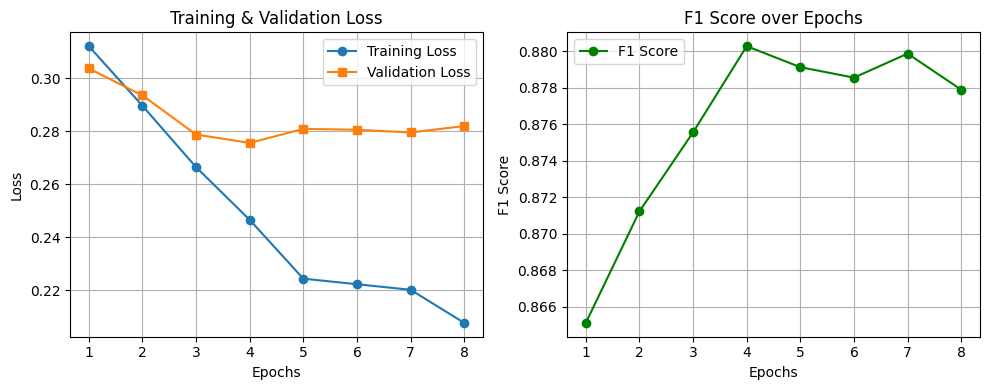

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your training results
epochs = np.arange(1, 9)
training_loss = [0.3122, 0.2897, 0.2665, 0.2466, 0.2244, 0.2223, 0.2202, 0.2077]
validation_loss = [0.303785, 0.293599, 0.278830, 0.275663, 0.280968, 0.280640, 0.279608, 0.282026]
f1_score = [0.865113, 0.871222, 0.875554, 0.880279, 0.879128, 0.878554, 0.879872, 0.877893]

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()

# Plot F1 Score
plt.subplot(1, 2, 2)
plt.plot(epochs, f1_score, label='F1 Score', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
example = datasetDict['test'][0]
print(f"datasetDict['test'][0]: {type(example)} {example.keys()}\n{example}")

In [ ]:
inputs = tokenizer(
    example['text'],
    truncation     = True,
    padding        = 'max_length',
    max_length     = max_length,
    return_tensors = 'pt'
)

In [ ]:
with torch.no_grad():  # Disable gradient calculation during prediction
    outputs = model(
        input_ids=inputs.input_ids.to(device),
        attention_mask=inputs.attention_mask.to(device)
    )


In [ ]:
probs = torch.sigmoid(outputs.logits)


In [ ]:
best_thresholds = [0.4, 0.3, 0.3, 0.3, 0.4, 0.5]
preds = np.zeros_like(probs)  # Initialize predictions array
for label_idx in range(num_labels):
  preds[:, label_idx] = (probs[:, label_idx] > best_thresholds[label_idx])  #.astype(int)

In [ ]:
print(f"probs: {type(probs)} shape={probs.shape}\n{probs}")
print(f"preds: {type(preds)} shape={preds.shape}\n{preds}")

In [ ]:
print(f"labels: {type(labels)} {len(labels)}\n{labels}")
# '390': False, '135': False, '136': True, '137': True, '138': True, '139': False}

In [ ]:
%%capture

def tune_thresholds(true_labels, probs, id2label):
  """
  Tune thresholds for each label to maximize F1 alone, as F1 balances precision and recall into a single metric.

  Args:
    true_labels: actual labels for the data                                      (numpy array of shape (num_samples, num_labels))
    probs      : predicted probabilities                                         (numpy array of shape (num_samples, num_labels))
    id2label   : dictionary mapping label indices (int) to label names (string)

  Returns:
    best_thresholds: best threshold for each label                                                      (numpy array of shape (num_labels,))
    best_metrics   : dictionary of best F1, precision_for_best_f1 and recall_for_best_f1 for each label (dictionary of numpy arrays)
  """
  thresholds      = np.linspace(0.1, 0.9, 9)
  best_thresholds = np.zeros(len(id2label))
  best_metrics    = {label: {'f1': 0.0, 'precision': 0.0, 'recall': 0.0} for label in id2label.values()}

  for label_idx, label in id2label.items():
    for threshold in thresholds:
      pred                     = (probs[:, label_idx] > threshold).astype(int)
      precision, recall, f1, _ = precision_recall_fscore_support(true_labels[:, label_idx], pred, average='binary', zero_division=0)
      if f1 > best_metrics[label]['f1']:
        best_thresholds[label_idx]       = threshold
        best_metrics[label]['f1']        = f1
        best_metrics[label]['precision'] = precision
        best_metrics[label]['recall']    = recall

  print("==== tune_thresholds ====")
  print(f"best_thresholds: {type(best_thresholds)} shape={best_thresholds.shape}\n{best_thresholds}")
  print(f"best_metrics   : {type(best_metrics)}    len={len(best_metrics)}      \n{json.dumps(best_metrics, indent=4)}")
  print("=========================")
  print()

  return best_thresholds, best_metrics

In [ ]:
%%capture

def compute_metrics_with_threshold_SAV(probs, label_ids, thresholds, id2label):

  #Compute metrics during evaluation or test, by applying tuned thresholds

  #logits  = eval_preds.predictions
  #labels  = eval_preds.label_ids
  #sigmoid = torch.nn.Sigmoid  # Sigmoid or numpy?
  #probs   = sigmoid(logits).cpu().numpy()
  preds   = np.zeros_like(probs)

  if threshold_tuning:
    # Apply per-label tuned threshold
    for label_idx in id2label.keys():
        preds[:, label_idx] = (probs[:, label_idx] > thresholds[label_idx]).astype(int)
  else:
    # threhsolds = None, apply a fixed threshold to all labels
    for label_idx in id2label.keys():
        preds[:, label_idx] = (probs[:, label_idx] > threshold).astype(int)

  # Compute metrics
  f1                    = f1_score               (label_ids, preds, average='micro')
  precision             = precision_score        (label_ids, preds, average='micro')
  recall                = recall_score           (label_ids, preds, average='micro')
  accuracy              = accuracy_score         (label_ids, preds)
  roc_auc               = roc_auc_score          (label_ids, probs, average='micro')  # multi_class="ovr" <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
  precision_recall_auc  = average_precision_score(label_ids, probs, average='micro')

  # Use id2label for target_names
  report = classification_report(label_ids, preds, target_names=id2label.values(), zero_division=0)

  if threshold_tuning:
    _thresholds = thresholds.tolist()
  else:
    _thresholds = threshold

  metrics = {
      'f1'                   : f1,
      'precision'            : precision,
      'recall'               : recall,
      'accuracy'             : accuracy,
      'roc_auc'              : roc_auc,
      'precision_recall_auc' : precision_recall_auc,
      'thresholds'           : _thresholds,
      'classification_report': report
  }

  return metrics

In [ ]:
%%capture

def compute_metrics_with_threshold_OLD(probs, label_ids, thresholds, id2label):
    """
    Compute metrics during evaluation or test, by applying tuned thresholds

    average:
    - 'micro'   : gives more weight to frequent labels     → best for imbalanced datasets where frequent labels are more important
    - 'macro'   : treats all labels equally                → best when you care about rare labels as much as frequent ones
    - 'weighted': like macro but considers label frequency → best if you want a compromise between macro and micro

    - 'macro' or 'weighted' AUC is often best because AUC isn't as affected by class imbalance as F1/Precision/Recall
    - 'macro'      AUC: usually the best because it treats all labels equally, avoiding the dominance of frequent labels
    - 'weighted'   AUC: similar to macro but considers label frequency
    - 'macro'   PR AUC: best for imbalanced datasets because it treats rare labels fairly
    - 'weighted PR AUC: also good, but slightly biased toward frequent labels

    PR AUC is better than ROC AUC when you care about positive examples in imbalanced data
    """
    average = 'macro'
    preds   = np.zeros_like(probs)

    # Apply per-label tuned threshold
    for label_idx in id2label.keys():
        preds[:, label_idx] = (probs[:, label_idx] > thresholds[label_idx]).astype(int)

    # Compute metrics
    f1        = f1_score       (label_ids, preds, average=average)
    precision = precision_score(label_ids, preds, average=average)
    recall    = recall_score   (label_ids, preds, average=average)
    accuracy  = accuracy_score (label_ids, preds)

    # Compute AUC scores with error handling
    try:
        roc_auc              = roc_auc_score          (label_ids, probs, average=average)
    except ValueError:
        roc_auc              = 0.0

    try:
        precision_recall_auc = average_precision_score(label_ids, probs, average=average)
    except ValueError:
        precision_recall_auc = 0.0

    # Compute per-class metrics (average = None)
    per_class_f1        = f1_score       (label_ids, preds, average=None)
    per_class_precision = precision_score(label_ids, preds, average=None)
    per_class_recall    = recall_score   (label_ids, preds, average=None)

    # Generate classification report
    report = classification_report(label_ids, preds, target_names=id2label.values(), zero_division=0)

    # Store metrics
    metrics = {
        'f1'                   : f1,
        'precision'            : precision,
        'recall'               : recall,
        'accuracy'             : accuracy,
        'roc_auc'              : roc_auc,
        'precision_recall_auc' : precision_recall_auc,
        'thresholds'           : thresholds.tolist(),
        'classification_report': report,
        'per_class_f1'         : per_class_f1,
        'per_class_precision'  : per_class_precision,
        'per_class_recall'     : per_class_recall
    }

    return metrics

In [ ]:
%%capture

def predict_with_optimized_thresholds_cuda(trainer, dataset, threshold_tuning=False, thresholds=None, threshold=threshold):
    """
    Predicts using trainer.predict(), with optional threshold tuning on GPU

    Parameters:
    - trainer         : Hugging Face Trainer or CustomTrainer instance
    - dataset         : dataset to predict on
    - id2label        : dictionary mapping label indices (int) to label names (string)
    - threshold_tuning: boolean to enable thresholds tuning per class (if evaluation, True, if prediction, False)
    - thresholds      : if evaluation, custom thresholds, if prediction, tuned thresholds (from evaluation)

    Returns:
    - best_thresholds (if threshold_tuning=True): optimized threshold for each label
    - best_metrics                              : computed with tuned thresholds whether for evaluation or prediction

    - metrics (if threshold_tuning=False): computed with fixed thresholds
    - metrics (if threshold_tuning=True): computed with tuned thresholds
    - predictions: final binary predictions
    - label_ids  : ground true labels from the dataset
    - best_thresholds (if threshold_tuning=True): optimized threshold per class
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Auto-detect GPU

    # Predict
    predictions_output = trainer.predict(dataset)        # <class 'transformers.trainer_utils.PredictionOutput'> len   = 3
    predictions_np     = predictions_output.predictions  # <class 'numpy.ndarray'>                               shape = (2400, 6)
    label_ids_np       = predictions_output.label_ids    # <class 'numpy.ndarray'>                               shape = (2400, 6)
    metrics_dict       = predictions_output.metrics      # <class 'dict'> (= trainer.evaluate results)           len   = 10

    print("==== predictions_output ====")
    print(f"predictions_output.predictions: {type(predictions_np)} shape={predictions_np.shape} \n{predictions_np}")
    print(f"predictions_output.label_ids  : {type(label_ids_np)}   shape={label_ids_np.shape}   \n{label_ids_np}")
    print(f"predictions_output.metrics    : {type(metrics_dict)}   len={len(metrics_dict)}      \n{json.dumps(metrics_dict, indent=4)}")

    # Convert NumPy arrays to PyTorch tensors (torch.from_numpy() keeps the NumPy array's memory layout, while torch.tensor() creates a new copy)
    logits      = torch.tensor(predictions_np, device=device)  # Move to GPU
    true_labels = torch.tensor(label_ids_np, device=device)    # Move to GPU

    print(f"logits     : {type(logits)}      shape={logits.shape}     \n{logits}")
    print(f"true_labels: {type(true_labels)} shape={true_labels.shape}\n{true_labels}")

    # Convert logits to probabilities using PyTorch (on GPU)
    probs = torch.sigmoid(logits)  # <class 'torch.Tensor'>  shape = (1200, 6)

    print(f"probs: {type(probs)} shape={probs.shape}\n{probs}")
    print("============================")
    print()

    num_labels = probs.shape[1]

    if threshold_tuning:
        best_thresholds = torch.full((num_labels,), threshold, device=device, dtype=torch.float32)  # Default to threshold

        # Define candidate thresholds (on GPU)
        threshold_candidates = torch.linspace(0.05, 0.95, 19, device=device)

        for label_idx in range(num_labels):
            best_f1 = 0
            for threshold in threshold_candidates:
                preds = (probs[:, label_idx] > threshold).int()

                # Convert to CPU for sklearn
                precision, recall, f1, _ = precision_recall_fscore_support(
                    true_labels[:, label_idx].cpu().numpy(),
                    preds.cpu().numpy(),
                    average='binary',
                    zero_division=0
                )

                if f1 > best_f1:
                    best_f1                    = f1
                    best_thresholds[label_idx] = threshold  # Store best threshold

        return probs, true_labels, best_thresholds

    # Apply provided thresholds (or default to 0.5)
    if thresholds is None:
        thresholds = torch.full((num_labels,), 0.5, device=device)  # Default to 0.5
    else:
        thresholds = torch.tensor(thresholds, device=device)  # Move thresholds to GPU

    preds = (probs > thresholds).int()

    return preds, true_labels, None